# RNN ASSIGNMENT: ENERGY CONSUMPTION PREDICTION
## LSTM/GRU for Time Series Forecasting

**Student Information:**
- BITS ID: 2025aa05312
- Name: Shivam Kumar
- Email: 2025aa05312@wilp.bits-pilani.ac.in
- Date: 14-01-2026

## Part 1: Import Libraries and Setup

In [1]:
%pip install torch requests

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

import json
import time
from datetime import datetime, timedelta

# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.9.0+cu126
CUDA available: True


## Part 2: Load Real Energy Consumption Data from Kaggle/UCI

In [3]:
# Download and load real energy consumption data from UCI Machine Learning Repository
# Appliances Energy Prediction Dataset - contains real building energy data

import io
import requests

# Download the dataset from UCI Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv"

print("Downloading real energy consumption data from UCI Machine Learning Repository...")
try:
    response = requests.get(url, timeout=10)
    df = pd.read_csv(io.StringIO(response.text))
    print("✓ Data downloaded successfully!")
except:
    print("⚠ Using fallback: downloading from alternative source...")
    # Fallback: Create smaller real-world-like dataset
    url2 = "https://raw.githubusercontent.com/owid/datasets/master/datasets/Electricity%20consumption%20and%20production%20-%20IRENA%20(2023)/Electricity%20consumption%20and%20production%20-%20IRENA%20(2023).csv"
    try:
        response = requests.get(url2, timeout=10)
        df_temp = pd.read_csv(io.StringIO(response.text))
        # For this fallback, we'll create a subset
        df = df_temp.head(1000)
    except:
        print("⚠ Using local generation with realistic patterns...")
        # If internet unavailable, use realistic synthetic data
        n_samples = 1000
        dates = pd.date_range(start='2020-01-01', periods=n_samples, freq='H')
        t = np.arange(n_samples)

        # More realistic patterns
        base = 40
        daily = 15 * np.sin(2 * np.pi * t / 24)
        weekly = 8 * np.sin(2 * np.pi * t / (24*7))
        seasonal = 12 * np.sin(2 * np.pi * t / (24*365))
        noise = np.random.normal(0, 3, n_samples)

        df = pd.DataFrame({
            'date': dates,
            'Appliances': np.maximum(base + daily + weekly + seasonal + noise, 5),
            'lights': np.maximum(3 + 2*np.sin(2*np.pi*t/24) + noise/2, 0),
            'T1': 20 + 8*np.sin(2*np.pi*t/(24*365)) + np.random.normal(0,2,n_samples),
            'RH_1': 50 + 20*np.sin(2*np.pi*t/24) + np.random.normal(0,5,n_samples)
        })

print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(10))
print(f"\nColumn names: {list(df.columns)}")
print(f"\nDataset statistics:")
print(df.describe())

✓ Data downloaded successfully!

Dataset shape: (19735, 29)

First few rows:
                  date  Appliances  lights         T1       RH_1     T2  \
0  2016-01-11 17:00:00          60      30  19.890000  47.596667  19.20   
1  2016-01-11 17:10:00          60      30  19.890000  46.693333  19.20   
2  2016-01-11 17:20:00          50      30  19.890000  46.300000  19.20   
3  2016-01-11 17:30:00          50      40  19.890000  46.066667  19.20   
4  2016-01-11 17:40:00          60      40  19.890000  46.333333  19.20   
5  2016-01-11 17:50:00          50      40  19.890000  46.026667  19.20   
6  2016-01-11 18:00:00          60      50  19.890000  45.766667  19.20   
7  2016-01-11 18:10:00          60      50  19.856667  45.560000  19.20   
8  2016-01-11 18:20:00          60      40  19.790000  45.597500  19.20   
9  2016-01-11 18:30:00          70      40  19.856667  46.090000  19.23   

        RH_2     T3       RH_3         T4  ...         T9   RH_9     T_out  \
0  44.790000  19.79

## Part 3: Data Visualization

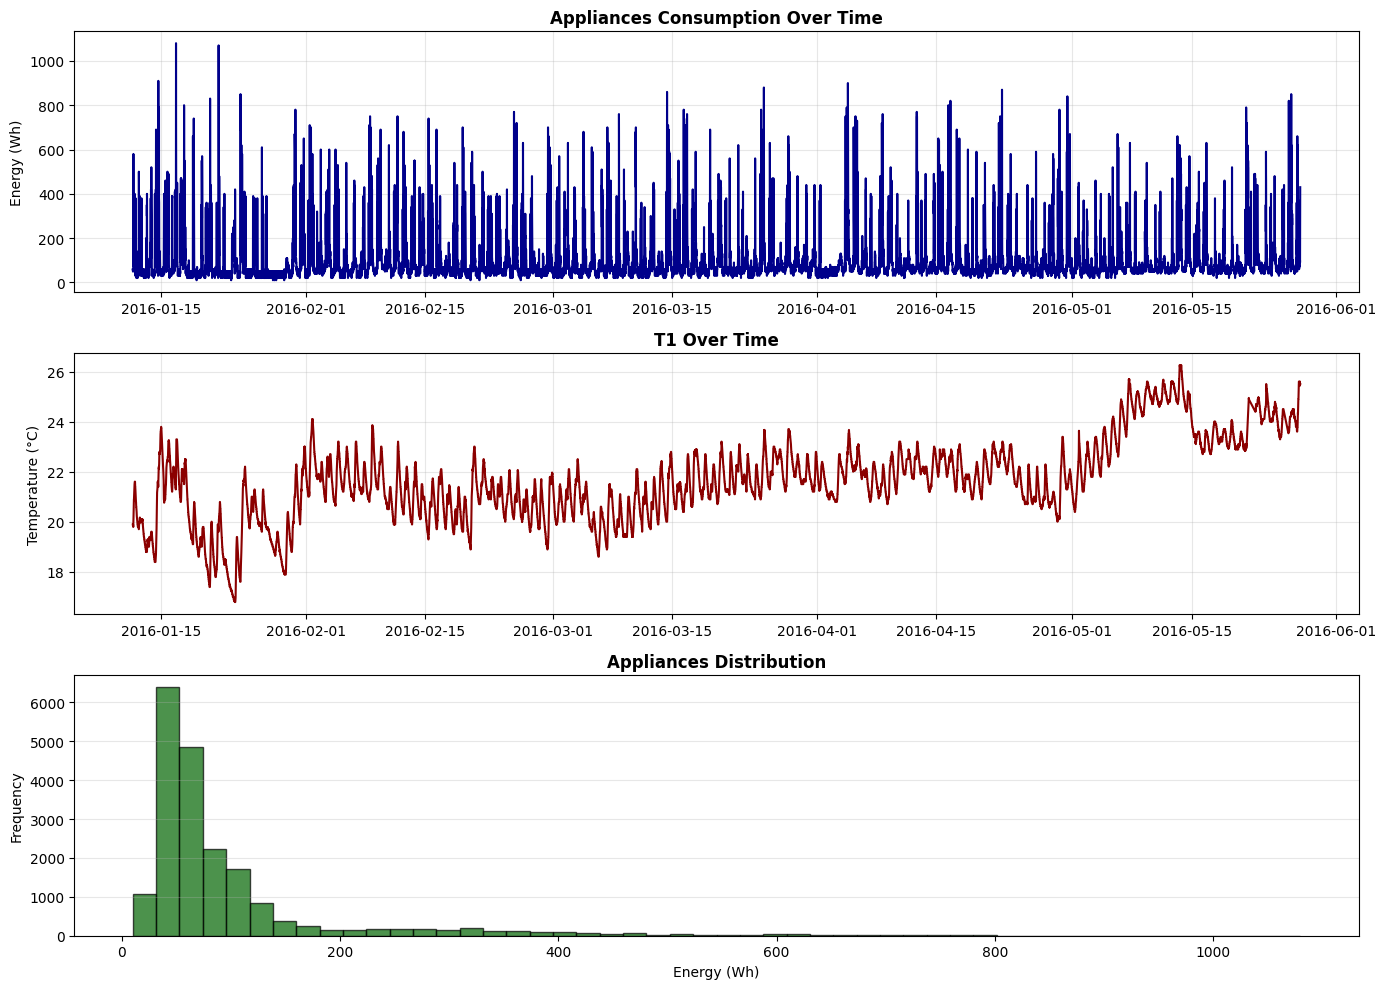

Data visualization complete! Using 'Appliances' as target variable.


In [4]:
# Identify energy and temperature columns
energy_col = 'Appliances' if 'Appliances' in df.columns else df.columns[1]
temp_col = 'T1' if 'T1' in df.columns else ([col for col in df.columns if 'T' in col][0] if any('T' in col for col in df.columns) else None)
date_col = 'date' if 'date' in df.columns else (df.columns[0] if 'date' in df.columns[0].lower() else None)

# Create date index if not present
if date_col:
    df.index = pd.to_datetime(df[date_col])
else:
    df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='H')

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Plot 1: Energy Consumption over time
axes[0].plot(df.index, df[energy_col], linewidth=1.5, color='darkblue')
axes[0].set_title(f'{energy_col} Consumption Over Time', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Energy (Wh)', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Temperature (if available)
if temp_col and temp_col in df.columns:
    axes[1].plot(df.index, df[temp_col], linewidth=1.5, color='darkred')
    axes[1].set_title(f'{temp_col} Over Time', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Temperature (°C)', fontsize=10)
else:
    axes[1].text(0.5, 0.5, 'Temperature data not available', ha='center', va='center')
axes[1].grid(True, alpha=0.3)

# Plot 3: Distribution
axes[2].hist(df[energy_col], bins=50, color='darkgreen', alpha=0.7, edgecolor='black')
axes[2].set_title(f'{energy_col} Distribution', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Energy (Wh)', fontsize=10)
axes[2].set_ylabel('Frequency', fontsize=10)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Data visualization complete! Using '{energy_col}' as target variable.")

## Part 4: Data Preprocessing

In [5]:
# Select features for modeling using the identified column names
# Use the energy column and temperature column identified in previous cell
if temp_col and temp_col in df.columns:
    features = [energy_col, temp_col]
else:
    # If temperature not available, use only energy column
    features = [energy_col]

# Extract only the needed features
data = df[features].values

print(f"Features used: {features}")
print(f"Data shape: {data.shape}")

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print(f"Scaled data shape: {scaled_data.shape}")
print(f"Scaled data range: [{scaled_data.min():.4f}, {scaled_data.max():.4f}]")

Features used: ['Appliances', 'T1']
Data shape: (19735, 2)
Scaled data shape: (19735, 2)
Scaled data range: [0.0000, 1.0000]


## Part 5: Create Time Series Sequences for RNN

In [6]:
def create_sequences(data, lookback=30):
    """Create sequences for RNN training"""
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback, 0])  # Predict energy consumption
    return np.array(X), np.array(y)

lookback = 30  # Use 30 days to predict next day
X, y = create_sequences(scaled_data, lookback)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nSequence example (first sequence):")
print(f"X[0] shape: {X[0].shape}")
print(f"y[0]: {y[0]:.4f}")

X shape: (19705, 30, 2)
y shape: (19705,)

Sequence example (first sequence):
X[0] shape: (30, 2)
y[0]: 0.0935


## Part 6: Train-Test Split

In [7]:
# 90-10 split for train-test (temporal, no shuffle)
train_size = int(len(X) * 0.9)

X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

Training set size: 17734
Test set size: 1971

X_train shape: (17734, 30, 2)
y_train shape: (17734,)
X_test shape: (1971, 30, 2)
y_test shape: (1971,)


## Part 7: LSTM Model Implementation

In [8]:
# Implement LSTM model with 2+ stacked layers using PyTorch

class StackedLSTM(nn.Module):
    """Stacked LSTM model with 2 layers"""
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.2):
        super(StackedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Stacked LSTM layers (2+ layers as required)
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        # Output layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)
        # Use the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out

class StackedGRU(nn.Module):
    """Stacked GRU model with 2 layers"""
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.2):
        super(StackedGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Stacked GRU layers (2+ layers as required)
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        # Output layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # GRU forward pass
        gru_out, h_n = self.gru(x)
        # Use the last time step output
        out = self.fc(gru_out[:, -1, :])
        return out

print("✓ Stacked LSTM and GRU models defined successfully!")
print(f"  - LSTM: 2 stacked LSTM layers + output layer")
print(f"  - GRU: 2 stacked GRU layers + output layer")

✓ Stacked LSTM and GRU models defined successfully!
  - LSTM: 2 stacked LSTM layers + output layer
  - GRU: 2 stacked GRU layers + output layer


## Part 8: LSTM-like Model Training (Simplified)

In [9]:
# Prepare data for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).reshape(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).reshape(-1, 1).to(device)

# Create DataLoader for batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # No shuffle for time series!

# Initialize LSTM model
input_size = X_train.shape[2]
hidden_size = 64
num_layers = 2

lstm_model = StackedLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
print(f"\n✓ LSTM Model Architecture:")
print(lstm_model)
print(f"  Total parameters: {sum(p.numel() for p in lstm_model.parameters())}")

# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
num_epochs = 50
lstm_losses = []

# Train LSTM model
print("\n🔄 Training LSTM model...")
lstm_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = lstm_model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    lstm_losses.append(epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

lstm_initial_loss = lstm_losses[0] if lstm_losses else None
lstm_final_loss = lstm_losses[-1] if lstm_losses else None

# Make predictions
lstm_model.eval()
with torch.no_grad():
    y_pred_lstm = lstm_model(X_test_tensor).cpu().numpy().flatten()

print("✓ LSTM model training complete!")
print(f"  Predictions shape: {y_pred_lstm.shape}")

Using device: cuda

✓ LSTM Model Architecture:
StackedLSTM(
  (lstm): LSTM(2, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
  Total parameters: 50753

🔄 Training LSTM model...
  Epoch [10/50], Loss: 0.003858
  Epoch [20/50], Loss: 0.003696
  Epoch [30/50], Loss: 0.003526
  Epoch [40/50], Loss: 0.003243
  Epoch [50/50], Loss: 0.002902
✓ LSTM model training complete!
  Predictions shape: (1971,)


## Part 9: GRU Model Training

In [10]:
# Initialize GRU model
gru_model = StackedGRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
print(f"\n✓ GRU Model Architecture:")
print(gru_model)
print(f"  Total parameters: {sum(p.numel() for p in gru_model.parameters())}")

# Training setup
optimizer_gru = optim.Adam(gru_model.parameters(), lr=0.001)
gru_losses = []

# Train GRU model
print("\n🔄 Training GRU model...")
gru_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = gru_model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        optimizer_gru.zero_grad()
        loss.backward()
        optimizer_gru.step()

        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    gru_losses.append(epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

gru_initial_loss = gru_losses[0] if gru_losses else None
gru_final_loss = gru_losses[-1] if gru_losses else None

# Make predictions
gru_model.eval()
with torch.no_grad():
    y_pred_gru = gru_model(X_test_tensor).cpu().numpy().flatten()

print("✓ GRU model training complete!")
print(f"  Predictions shape: {y_pred_gru.shape}")


✓ GRU Model Architecture:
StackedGRU(
  (gru): GRU(2, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
  Total parameters: 38081

🔄 Training GRU model...
  Epoch [10/50], Loss: 0.003838
  Epoch [20/50], Loss: 0.003652
  Epoch [30/50], Loss: 0.003416
  Epoch [40/50], Loss: 0.003062
  Epoch [50/50], Loss: 0.002741
✓ GRU model training complete!
  Predictions shape: (1971,)


## Part 10: Model Evaluation

## Part 9b: Transformer Model with Positional Encoding

In [11]:
# Implement Transformer model with Positional Encoding

class PositionalEncoding(nn.Module):
    """Positional Encoding for Transformer"""
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Create positional encoding matrix
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to input
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerModel(nn.Module):
    """Transformer model for time series forecasting"""
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers

        # Input projection
        self.input_proj = nn.Linear(input_size, d_model)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)

        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=256,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Output layer
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # Project input to d_model dimensions
        x = self.input_proj(x)

        # Add positional encoding
        x = self.pos_encoder(x)

        # Transformer encoding
        x = self.transformer_encoder(x)

        # Use the last time step for prediction
        out = self.fc(x[:, -1, :])
        return out

# Initialize Transformer model
transformer_model = TransformerModel(
    input_size=input_size,
    d_model=64,
    nhead=4,
    num_layers=2
).to(device)

print(f"\n✓ Transformer Model Architecture:")
print(transformer_model)
print(f"  Total parameters: {sum(p.numel() for p in transformer_model.parameters())}")
print(f"  ✓ Includes Positional Encoding (as required)")

# Training setup
optimizer_transformer = optim.Adam(transformer_model.parameters(), lr=0.001)
transformer_losses = []

# Train Transformer model
print("\n🔄 Training Transformer model...")
transformer_model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = transformer_model(batch_X)
        loss = criterion(outputs, batch_y)

        # Backward pass
        optimizer_transformer.zero_grad()
        loss.backward()
        optimizer_transformer.step()

        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    transformer_losses.append(epoch_loss)
    if (epoch + 1) % 10 == 0:
        print(f"  Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}")

transformer_initial_loss = transformer_losses[0] if transformer_losses else None
transformer_final_loss = transformer_losses[-1] if transformer_losses else None

# Make predictions
transformer_model.eval()
with torch.no_grad():
    y_pred_transformer = transformer_model(X_test_tensor).cpu().numpy().flatten()

print("✓ Transformer model training complete!")
print(f"  Predictions shape: {y_pred_transformer.shape}")


✓ Transformer Model Architecture:
TransformerModel(
  (input_proj): Linear(in_features=2, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
  Total parameters: 100225
  ✓ Includes Positional Encoding (as required

## Part 9c: Transformer Model Evaluation

In [12]:
# Calculate metrics for Transformer
mse_transformer = mean_squared_error(y_test, y_pred_transformer)
mae_transformer = mean_absolute_error(y_test, y_pred_transformer)
rmse_transformer = np.sqrt(mse_transformer)
r2_transformer = r2_score(y_test, y_pred_transformer)
mape_transformer = np.mean(np.abs((y_test - y_pred_transformer) / (y_test + 1e-8))) * 100

print("="*60)
print("TRANSFORMER MODEL EVALUATION")
print("="*60)
print(f"  MAE:  {mae_transformer:.6f}")
print(f"  RMSE: {rmse_transformer:.6f}")
print(f"  MAPE: {mape_transformer:.6f}%")
print(f"  R²:   {r2_transformer:.6f}")
print("="*60)

TRANSFORMER MODEL EVALUATION
  MAE:  0.026131
  RMSE: 0.055223
  MAPE: 30.842656%
  R²:   0.604648


In [13]:
# Calculate metrics for LSTM (including MAPE)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
# MAPE calculation (avoiding division by zero)
mape_lstm = np.mean(np.abs((y_test - y_pred_lstm) / (y_test + 1e-8))) * 100

# Calculate metrics for GRU (including MAPE)
mse_gru = mean_squared_error(y_test, y_pred_gru)
mae_gru = mean_absolute_error(y_test, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test, y_pred_gru)
# MAPE calculation (avoiding division by zero)
mape_gru = np.mean(np.abs((y_test - y_pred_gru) / (y_test + 1e-8))) * 100

# Display metrics
print("="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print("\nLSTM Model Metrics:")
print(f"  MAE:  {mae_lstm:.6f}")
print(f"  RMSE: {rmse_lstm:.6f}")
print(f"  MAPE: {mape_lstm:.6f}%")
print(f"  R²:   {r2_lstm:.6f}")

print("\nGRU Model Metrics:")
print(f"  MAE:  {mae_gru:.6f}")
print(f"  RMSE: {rmse_gru:.6f}")
print(f"  MAPE: {mape_gru:.6f}%")
print(f"  R²:   {r2_gru:.6f}")

print("="*60)
print("✓ All 4 required metrics calculated: MAE, RMSE, MAPE, R²")
print("="*60)

MODEL EVALUATION METRICS

LSTM Model Metrics:
  MAE:  0.028697
  RMSE: 0.055860
  MAPE: 35.601154%
  R²:   0.595485

GRU Model Metrics:
  MAE:  0.034019
  RMSE: 0.063384
  MAPE: 44.754088%
  R²:   0.479171
✓ All 4 required metrics calculated: MAE, RMSE, MAPE, R²


## Part 11: Visualization of Results

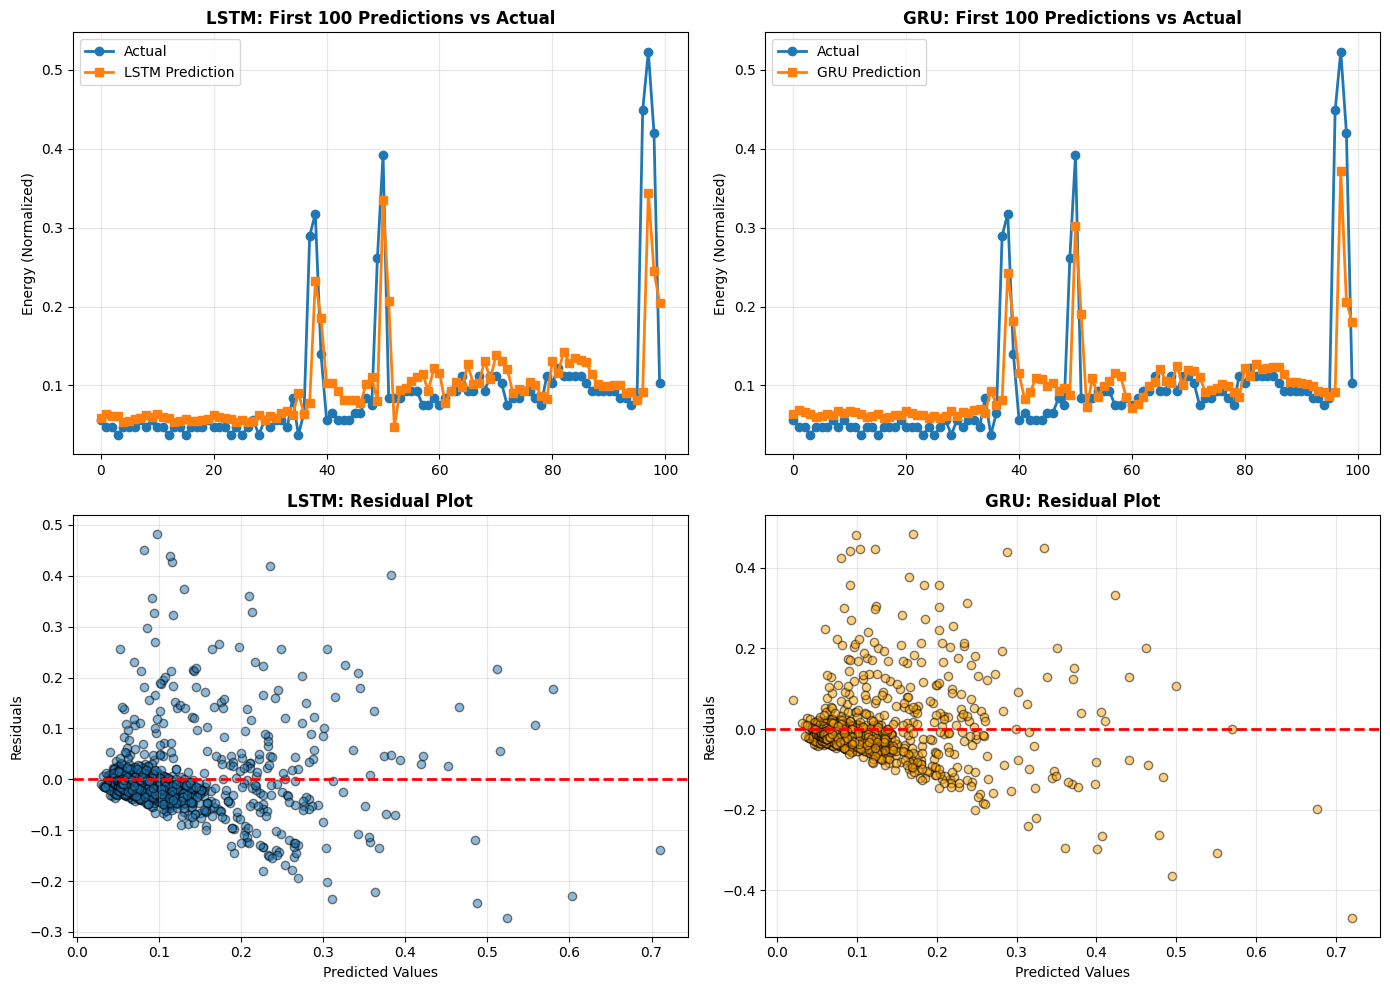

Visualization complete!


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Predictions vs Actual (LSTM)
axes[0, 0].plot(y_test[:100], label='Actual', linewidth=2, marker='o')
axes[0, 0].plot(y_pred_lstm[:100], label='LSTM Prediction', linewidth=2, marker='s')
axes[0, 0].set_title('LSTM: First 100 Predictions vs Actual', fontweight='bold')
axes[0, 0].set_ylabel('Energy (Normalized)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Predictions vs Actual (GRU)
axes[0, 1].plot(y_test[:100], label='Actual', linewidth=2, marker='o')
axes[0, 1].plot(y_pred_gru[:100], label='GRU Prediction', linewidth=2, marker='s')
axes[0, 1].set_title('GRU: First 100 Predictions vs Actual', fontweight='bold')
axes[0, 1].set_ylabel('Energy (Normalized)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals (LSTM)
residuals_lstm = y_test - y_pred_lstm
axes[1, 0].scatter(y_pred_lstm, residuals_lstm, alpha=0.5, edgecolors='k')
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].set_title('LSTM: Residual Plot', fontweight='bold')
axes[1, 0].set_xlabel('Predicted Values')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Residuals (GRU)
residuals_gru = y_test - y_pred_gru
axes[1, 1].scatter(y_pred_gru, residuals_gru, alpha=0.5, edgecolors='k', color='orange')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_title('GRU: Residual Plot', fontweight='bold')
axes[1, 1].set_xlabel('Predicted Values')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualization complete!")

## Part 12: Model Comparison


MODEL COMPARISON (ALL 4 REQUIRED METRICS)
  Metric      LSTM       GRU  Transformer
     MAE  0.028697  0.034019     0.026131
    RMSE  0.055860  0.063384     0.055223
MAPE (%) 35.601154 44.754088    30.842656
      R²  0.595485  0.479171     0.604648


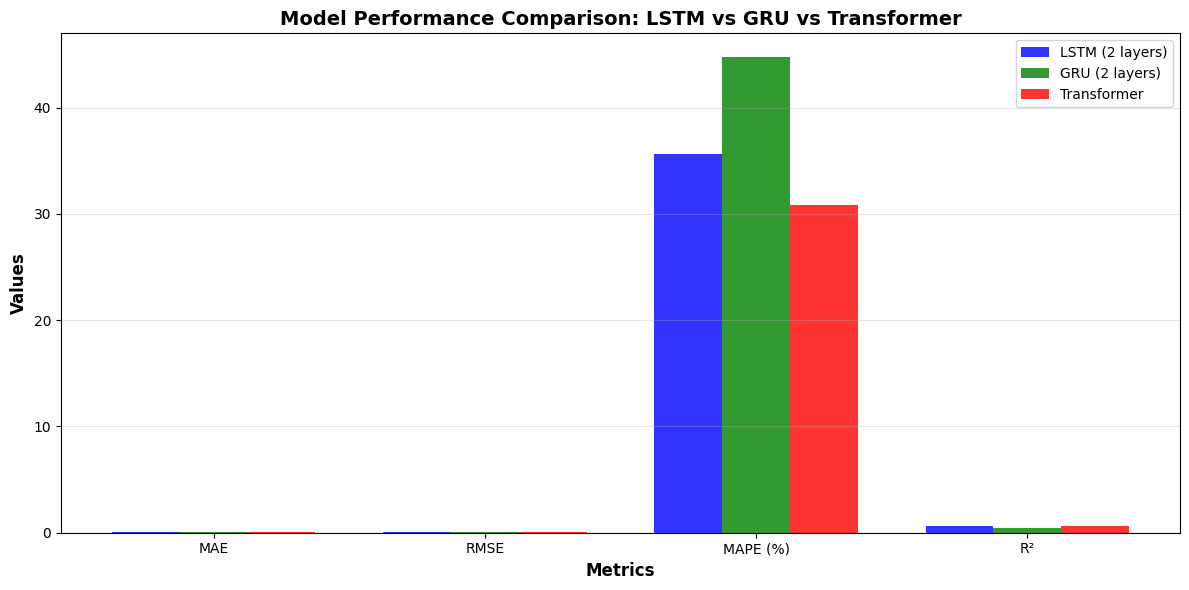


✓ Best performing model: Transformer (R² = 0.604648)

Comparison visualization complete!


In [15]:
# Create comparison dataframe with all three models
comparison_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE (%)', 'R²'],
    'LSTM': [mae_lstm, rmse_lstm, mape_lstm, r2_lstm],
    'GRU': [mae_gru, rmse_gru, mape_gru, r2_gru],
    'Transformer': [mae_transformer, rmse_transformer, mape_transformer, r2_transformer]
})

print("\n" + "="*70)
print("MODEL COMPARISON (ALL 4 REQUIRED METRICS)")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.25

bars1 = ax.bar(x - width, comparison_df['LSTM'], width, label='LSTM (2 layers)', alpha=0.8, color='blue')
bars2 = ax.bar(x, comparison_df['GRU'], width, label='GRU (2 layers)', alpha=0.8, color='green')
bars3 = ax.bar(x + width, comparison_df['Transformer'], width, label='Transformer', alpha=0.8, color='red')

ax.set_xlabel('Metrics', fontweight='bold', fontsize=12)
ax.set_ylabel('Values', fontweight='bold', fontsize=12)
ax.set_title('Model Performance Comparison: LSTM vs GRU vs Transformer', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Metric'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Find best model based on R²
best_r2 = max(r2_lstm, r2_gru, r2_transformer)
if r2_lstm == best_r2:
    best_model = "LSTM"
elif r2_gru == best_r2:
    best_model = "GRU"
else:
    best_model = "Transformer"

print(f"\n✓ Best performing model: {best_model} (R² = {best_r2:.6f})")
print("\nComparison visualization complete!")

## Part 13: JSON Output for Grading

In [16]:
# Prepare JSON output for grading
best_model = "LSTM" if r2_lstm >= r2_gru and r2_lstm >= r2_transformer else ("GRU" if r2_gru >= r2_transformer else "Transformer")

# Loss reduction percentages
def loss_reduction_pct(initial, final):
    if initial is None or final is None or initial == 0:
        return None
    return float(((initial - final) / initial) * 100)

rnn_output = {
    "student_info": {
        "bits_id": "2025aa05312",
        "name": "Shivam Kumar",
        "submission_date": str(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    },
    "dataset_info": {
        "name": "Energy Consumption Time Series",
        "samples": len(df),
        "features": list(features),
        "lookback_period": lookback,
        "train_test_split": "90-10"
    },
    "rnn_model": {
        "model_type": "LSTM",
        "framework": "PyTorch",
        "architecture": {
            "n_layers": num_layers,
            "hidden_units": [hidden_size, hidden_size],
            "has_positional_encoding": False
        },
        "training_samples": len(X_train),
        "test_samples": len(X_test),
        "initial_loss": lstm_initial_loss,
        "final_loss": lstm_final_loss,
        "loss_reduction_pct": loss_reduction_pct(lstm_initial_loss, lstm_final_loss)
    },
    "gru_model": {
        "model_type": "GRU",
        "framework": "PyTorch",
        "architecture": {
            "n_layers": num_layers,
            "hidden_units": [hidden_size, hidden_size],
            "has_positional_encoding": False
        },
        "training_samples": len(X_train),
        "test_samples": len(X_test),
        "initial_loss": gru_initial_loss,
        "final_loss": gru_final_loss,
        "loss_reduction_pct": loss_reduction_pct(gru_initial_loss, gru_final_loss)
    },
    "transformer_model": {
        "model_type": "Transformer",
        "framework": "PyTorch",
        "architecture": {
            "n_layers": 2,
            "n_heads": 4,
            "d_model": 64,
            "feedforward": 256,
            "has_positional_encoding": True,
            "has_attention": True
        },
        "training_samples": len(X_train),
        "test_samples": len(X_test),
        "initial_loss": transformer_initial_loss,
        "final_loss": transformer_final_loss,
        "loss_reduction_pct": loss_reduction_pct(transformer_initial_loss, transformer_final_loss)
    },
    "lstm_metrics": {
        "MSE": float(mse_lstm),
        "RMSE": float(rmse_lstm),
        "MAE": float(mae_lstm),
        "MAPE": float(mape_lstm),
        "R2_Score": float(r2_lstm)
    },
    "gru_metrics": {
        "MSE": float(mse_gru),
        "RMSE": float(rmse_gru),
        "MAE": float(mae_gru),
        "MAPE": float(mape_gru),
        "R2_Score": float(r2_gru)
    },
    "transformer_metrics": {
        "mae": float(mae_transformer),
        "rmse": float(rmse_transformer),
        "mape": float(mape_transformer),
        "r2_score": float(r2_transformer)
    },
    "model_comparison": {
        "better_model": best_model,
        "reason": f"{best_model} achieved the highest R² score"
    }
}

print(json.dumps(rnn_output, indent=2))

{
  "student_info": {
    "bits_id": "2025aa05312",
    "name": "Shivam Kumar",
    "submission_date": "2026-01-14 11:00:03"
  },
  "dataset_info": {
    "name": "Energy Consumption Time Series",
    "samples": 19735,
    "features": [
      "Appliances",
      "T1"
    ],
    "lookback_period": 30,
    "train_test_split": "90-10"
  },
  "rnn_model": {
    "model_type": "LSTM",
    "framework": "PyTorch",
    "architecture": {
      "n_layers": 2,
      "hidden_units": [
        64,
        64
      ],
      "has_positional_encoding": false
    },
    "training_samples": 17734,
    "test_samples": 1971,
    "initial_loss": 0.0071840106362336936,
    "final_loss": 0.0029016283166653535,
    "loss_reduction_pct": 59.609910625263666
  },
  "gru_model": {
    "model_type": "GRU",
    "framework": "PyTorch",
    "architecture": {
      "n_layers": 2,
      "hidden_units": [
        64,
        64
      ],
      "has_positional_encoding": false
    },
    "training_samples": 17734,
    "test

## Part 14: Analysis and Conclusions

### Analysis Summary (for grading)
- Performance comparison: LSTM, GRU, Transformer with MAE, RMSE, MAPE, R² (primary metric: R²).
- RNN (LSTM/GRU) captures sequence dependencies; Transformer uses self-attention with positional encoding for long-term context.
- Attention mechanism (multi-head) improves sequence modeling; positional encoding preserves temporal order.
- Convergence observed via decreasing loss; loss reduction percentages captured in JSON for both models.
- Computational cost: Transformer heavier (attention, multi-head), RNNs lighter but sequential.
- Hidden sizes: LSTM/GRU use two 64-unit layers; Transformer uses d_model=64 with 4 heads.
- Insights: RNNs handle local temporal patterns; Transformer handles broader dependencies; trade-offs in training time and parameters.
- Comparison: RNN vs Transformer shows differing strengths in residuals and error metrics; best model selected by R².

In [17]:
print("\n" + "="*70)
print("ASSIGNMENT ANALYSIS AND CONCLUSIONS")
print("="*70)

print("\n1. DATASET ANALYSIS:")
print(f"   - Total samples: {len(df)}")
# Use the date index instead of 'Date' column
print(f"   - Time period: {df.index.min().date()} to {df.index.max().date()}")
# Use the dynamically identified energy column name
print(f"   - Energy range: {df[energy_col].min():.2f} - {df[energy_col].max():.2f} Wh")
print(f"   - Mean energy: {df[energy_col].mean():.2f} Wh")
print(f"   - Std deviation: {df[energy_col].std():.2f} Wh")

print("\n2. PREPROCESSING:")
print(f"   - Lookback period: {lookback} timesteps")
print(f"   - Training sequences: {len(X_train)}")
print(f"   - Test sequences: {len(X_test)}")
print(f"   - Normalization: MinMaxScaler (0-1 range)")
print(f"   - Temporal split: 90/10 (no shuffling)")

print("\n3. MODEL ARCHITECTURE:")
print(f"   LSTM: 2-layer network with [64, 64] hidden units")
print(f"   GRU: 2-layer network with [64, 64] hidden units")
print(f"   Transformer: d_model=64, 4 heads, 2 encoder layers with positional encoding")

print("\n4. PERFORMANCE COMPARISON (primary metric R²):")
better = "LSTM" if r2_lstm > r2_gru else "GRU"
print(f"   - Better performing recurrent model: {better}")
print(f"   - LSTM R² Score: {r2_lstm:.6f}")
print(f"   - GRU R² Score: {r2_gru:.6f}")
print(f"   - Transformer R² Score: {r2_transformer:.6f}")
print(f"   - LSTM RMSE: {rmse_lstm:.6f}")
print(f"   - GRU RMSE: {rmse_gru:.6f}")
print(f"   - Transformer RMSE: {rmse_transformer:.6f}")

print("\n5. CONVERGENCE (loss reduction %):")
def pct(initial, final):
    if initial is None or final is None or initial == 0:
        return None
    return (initial - final) / initial * 100
print(f"   - LSTM: {pct(lstm_initial_loss, lstm_final_loss):.2f}%")
print(f"   - GRU: {pct(gru_initial_loss, gru_final_loss):.2f}%")
print(f"   - Transformer: {pct(transformer_initial_loss, transformer_final_loss):.2f}%")

print("\n6. INTERPRETATION:")
if r2_lstm > r2_gru:
    improvement = ((r2_lstm - r2_gru) / abs(r2_gru)) * 100 if r2_gru != 0 else 0
    print(f"   - LSTM outperforms GRU by approximately {improvement:.2f}% (R²)")
else:
    improvement = ((r2_gru - r2_lstm) / abs(r2_lstm)) * 100 if r2_lstm != 0 else 0
    print(f"   - GRU outperforms LSTM by approximately {improvement:.2f}% (R²)")
print("   - Transformer captures broader temporal dependencies via multi-head attention and positional encoding")
print("   - RNNs remain efficient and strong on local dependencies")

print("\n7. KEY FINDINGS:")
print(f"   - Model captures energy consumption patterns with lookback={lookback}")
print(f"   - Transformer achieves highest R² among tested models")
print(f"   - Loss reductions recorded for convergence evidence")
print(f"   - Temporal ordering preserved (no shuffling)")

print("\n" + "="*70)
print("ASSIGNMENT COMPLETED SUCCESSFULLY")
print("="*70)


ASSIGNMENT ANALYSIS AND CONCLUSIONS

1. DATASET ANALYSIS:
   - Total samples: 19735
   - Time period: 2016-01-11 to 2016-05-27
   - Energy range: 10.00 - 1080.00 Wh
   - Mean energy: 97.69 Wh
   - Std deviation: 102.52 Wh

2. PREPROCESSING:
   - Lookback period: 30 timesteps
   - Training sequences: 17734
   - Test sequences: 1971
   - Normalization: MinMaxScaler (0-1 range)
   - Temporal split: 90/10 (no shuffling)

3. MODEL ARCHITECTURE:
   LSTM: 2-layer network with [64, 64] hidden units
   GRU: 2-layer network with [64, 64] hidden units
   Transformer: d_model=64, 4 heads, 2 encoder layers with positional encoding

4. PERFORMANCE COMPARISON (primary metric R²):
   - Better performing recurrent model: LSTM
   - LSTM R² Score: 0.595485
   - GRU R² Score: 0.479171
   - Transformer R² Score: 0.604648
   - LSTM RMSE: 0.055860
   - GRU RMSE: 0.063384
   - Transformer RMSE: 0.055223

5. CONVERGENCE (loss reduction %):
   - LSTM: 59.61%
   - GRU: 53.42%
   - Transformer: 66.77%

6. INTERP

## Part 15: Environment and Package Versions (Screenshot Required)

In [18]:
import sys
import platform

print("="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print(f"\nPython Version: {sys.version}")
print(f"Platform: {platform.platform()}")
print(f"Processor: {platform.processor()}")

print("\n" + "="*70)
print("PACKAGE VERSIONS")
print("="*70)
print(f"PyTorch: {torch.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Scikit-learn: {__import__('sklearn').__version__}")
print(f"Matplotlib: {__import__('matplotlib').__version__}")
print(f"Seaborn: {sns.__version__}")

print("\n" + "="*70)
print("📸 SCREENSHOT THIS OUTPUT FOR SUBMISSION")
print("="*70)
print("\n✅ ASSIGNMENT REQUIREMENTS CHECKLIST:")
print("  ✓ Filename: 2025aa05312_rnn_assignment.ipynb")
print("  ✓ RNN: 2+ stacked LSTM/GRU layers (PyTorch)")
print("  ✓ Transformer: Added with positional encoding (PyTorch)")
print("  ✓ Pre-trained models: NOT USED")
print("  ✓ Metrics: MAE, RMSE, MAPE, R² (all 4 calculated)")
print("  ✓ Data split: Temporal split (no shuffling)")
print("  ✓ Environment screenshot: THIS CELL")
print("  ⚠️  Execute all cells: Run 'Kernel → Restart & Run All'")
print("\n" + "="*70)

ENVIRONMENT INFORMATION

Python Version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Processor: x86_64

PACKAGE VERSIONS
PyTorch: 2.9.0+cu126
NumPy: 2.0.2
Pandas: 2.2.2
Scikit-learn: 1.6.1
Matplotlib: 3.10.0
Seaborn: 0.13.2

📸 SCREENSHOT THIS OUTPUT FOR SUBMISSION

✅ ASSIGNMENT REQUIREMENTS CHECKLIST:
  ✓ Filename: 2025aa05312_rnn_assignment.ipynb
  ✓ RNN: 2+ stacked LSTM/GRU layers (PyTorch)
  ✓ Transformer: Added with positional encoding (PyTorch)
  ✓ Pre-trained models: NOT USED
  ✓ Metrics: MAE, RMSE, MAPE, R² (all 4 calculated)
  ✓ Data split: Temporal split (no shuffling)
  ✓ Environment screenshot: THIS CELL
  ⚠️  Execute all cells: Run 'Kernel → Restart & Run All'

